In [1]:
import pandas as pd
import numpy as np

# dataset
df = pd.read_csv("../datasetintermedio.csv")

#eliminar columna es_outlier
df = df.drop(columns=['es_outlier'])

df.head()

,Año,Puertas,Con cámara de retroceso,Kilómetros,Precio_usd,Marca_Alfa Romeo,Marca_Audi,Marca_BAIC,Marca_BMW,Marca_Chery,...,Combustible_Mild Hybrid,Combustible_Nafta,Combustible_Nafta/GNC,Transmision_Automática,Transmision_Automática secuencial,Transmision_Manual,Transmision_Semiautomática,Vendedor_concesionaria,Vendedor_particular,Vendedor_tienda
0,2020.0,5.0,0,640000,17596.566524,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,2024.0,5.0,1,0,48068.583691,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,2019.0,5.0,0,653000,28300.000000,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,2017.0,5.0,0,768980,17244.635193,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,2021.0,5.0,1,1090000,23000.000000,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


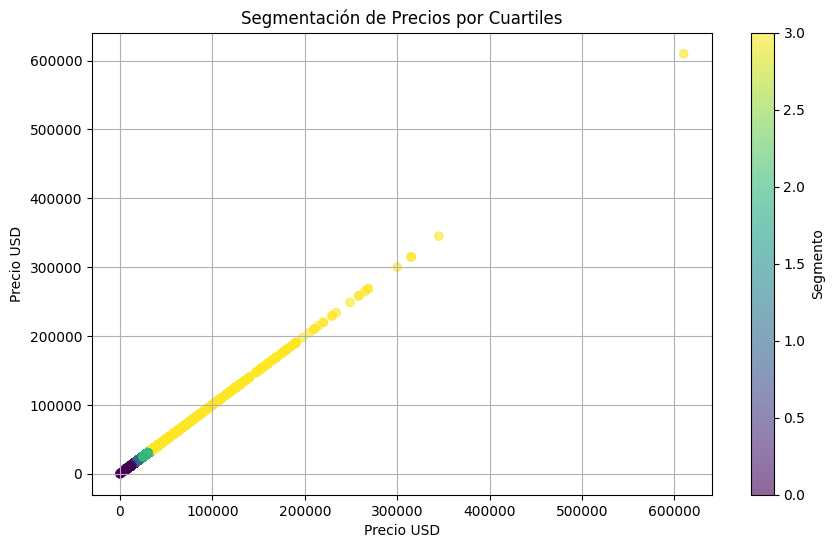

Cantidad por segmento:
segmento
0    4635
1    4497
2    4558
3    4564
Name: count, dtype: int64


In [2]:
import pandas as pd

# Crear columna de cuartil del precio normalizado
df['segmento'] = pd.qcut(df['Precio_usd'], q=4, labels=[0, 1, 2, 3])
df['segmento'] = df['segmento'].astype(int)

# grafico los precios en plano coloreados por segmentos 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df['Precio_usd'], df['Precio_usd'], c=df['segmento'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Segmento')
plt.xlabel('Precio USD')
plt.ylabel('Precio USD')
plt.title('Segmentación de Precios por Cuartiles')
plt.grid(True)
plt.show()

# Cantidad por cuartil
cantidad_por_segmento = df['segmento'].value_counts().sort_index()
print("Cantidad por segmento:")
print(cantidad_por_segmento)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier

# 1. Separar X e y
X = df.drop(columns=['Precio_usd', 'segmento', 'es_outlier'])
y = df['segmento']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

# 2. Crear pipeline con escalador y MLP
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=500, random_state=42))
])

# 3. Definir espacio de búsqueda sobre el paso 'mlp'
param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64)],
    'mlp__activation':           ['relu', 'tanh'],
    'mlp__alpha':                [0.0001, 0.001, 0.01],
    'mlp__learning_rate':        ['constant', 'adaptive']
}

# 4. GridSearchCV sobre pipeline
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# 5. Entrenar y evaluar
grid.fit(X_train, y_train)
print("✅ Mejores hiperparámetros:", grid.best_params_)
print("🎯 Accuracy en test:", grid.score(X_test, y_test))


Fitting 3 folds for each of 60 candidates, totalling 180 fits


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.wa

✅ Mejores hiperparámetros: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (32,), 'mlp__learning_rate': 'constant'}
🎯 Accuracy en test: 0.780236634531113


In [9]:
# Usar el mejor modelo MLP ya entrenado
mlp_final = grid.best_estimator_

# Predecir el segmento para todo el dataset (sin usar precio)
X_full = df.drop(columns=['Precio_usd', 'segmento', 'es_outlier'])
df['segmento_predicho'] = mlp_final.predict(X_full)

df.head()

,Año,Puertas,Con cámara de retroceso,Kilómetros,Precio_usd,Marca_Alfa Romeo,Marca_Audi,Marca_BAIC,Marca_BMW,Marca_Chery,...,Transmision_Automática,Transmision_Automática secuencial,Transmision_Manual,Transmision_Semiautomática,Vendedor_concesionaria,Vendedor_particular,Vendedor_tienda,es_outlier,segmento,segmento_predicho
0,2020.0,5.0,0,640000,17596.566524,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,1
1,2024.0,5.0,1,0,48068.583691,0,0,0,0,0,...,0,1,0,0,0,0,1,1,3,3
2,2019.0,5.0,0,653000,28300.000000,0,0,0,0,0,...,1,0,0,0,0,1,0,0,2,2
3,2017.0,5.0,0,768980,17244.635193,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,1
4,2021.0,5.0,1,1090000,23000.000000,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,2


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Guardar modelos y métricas
modelos_rf = {}
resultados = []

# Espacio de búsqueda ampliado
param_grid = {
    'n_estimators':     [100, 200, 500],
    'max_depth':        [5, 10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2],
    'max_features':     ['sqrt', 'log2', 0.5, 0.75]
}

for segmento in sorted(df['segmento_predicho'].unique()):
    print(f"\n🔍 Optimizando segmento {segmento}...")
    df_seg = df[df['segmento_predicho'] == segmento].copy()
    
    # Features y target
    X = df_seg.drop(columns=['Precio_usd','segmento','es_outlier','segmento_predicho'])
    y = df_seg['Precio_usd']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42
    )
    
    # Transformación logarítmica del target
    y_train_log = np.log1p(y_train)
    
    # Configurar GridSearchCV optimizando MAE
    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(
        rf,
        param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train_log)
    
    # Mejor modelo
    best_rf = grid.best_estimator_
    modelos_rf[segmento] = best_rf
    
    # Predicción: del espacio log a escala original
    y_pred_log = best_rf.predict(X_test)
    y_pred     = np.expm1(y_pred_log)
    
    # Métricas en la escala original
    resultados.append({
        'segmento':      segmento,
        'MAE':           mean_absolute_error(y_test, y_pred),
        'RMSE':          np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2':            r2_score(y_test, y_pred),
        'mejores_params': grid.best_params_
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)



🔍 Optimizando segmento 0...

🔍 Optimizando segmento 1...

🔍 Optimizando segmento 2...

🔍 Optimizando segmento 3...
   segmento          MAE         RMSE        R2  \
0         0  1321.099019  1926.859555  0.649055   
1         1  1655.103123  2932.737500  0.507933   
2         2  2643.733223  3780.710492  0.364721   
3         3  5060.711764  9548.711679  0.840739   

                                      mejores_params  
0  {'max_depth': 10, 'max_features': 0.5, 'min_sa...  
1  {'max_depth': None, 'max_features': 0.5, 'min_...  
2  {'max_depth': 20, 'max_features': 0.75, 'min_s...  
3  {'max_depth': None, 'max_features': 0.5, 'min_...  


In [13]:
# Partimos de tu df_resultados que tiene la columna 'mejores_params' con dicts
import pandas as pd

# 1. Convertir la columna de dicts en un DataFrame
params_df = pd.json_normalize(df_resultados['mejores_params'])

# 2. Concatenar ese DataFrame al original (y opcionalmente eliminar la columna de dicts)
df_final = pd.concat(
    [ df_resultados.drop(columns=['mejores_params']), 
      params_df ],
    axis=1
)

print(df_final)


   segmento          MAE         RMSE        R2  max_depth  max_features  \
0         0  1321.099019  1926.859555  0.649055       10.0          0.50   
1         1  1655.103123  2932.737500  0.507933        NaN          0.50   
2         2  2643.733223  3780.710492  0.364721       20.0          0.75   
3         3  5060.711764  9548.711679  0.840739        NaN          0.50   

   min_samples_leaf  min_samples_split  n_estimators  
0                 2                  2           500  
1                 1                  5           500  
2                 2                  5           200  
3                 1                  2           500  
